# Regressione Per Dati Trentino

In questo notebook affrontiamo il problema della regressione per i dati di tutto il Trentino dividendo i giorni in due fasce orarie: 8-19 sarà quella a cui mi riferirò come 'diurna' e 19-24 come 'notturna'. Verranno utilizzati due modelli: Random Forest e XGBoost, di cui entrambi verranno ottimizzati tramite GridSearchCV implementando quindi una cross-validation

In [12]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

Carivo i dati dal dataset preparato in precedenza

In [13]:
#Giorno
col_stran_nov_df_day = pd.read_csv('../../data/processed/Regressione/Trentino/df_day_nov.csv')
col_stran_dec_df_day = pd.read_csv('../../data/processed/Regressione/Trentino/df_day_dec.csv')
col_stran_dec_df_day['DAY'] = col_stran_dec_df_day['DAY'] + 30 #così dopo concateno con novembre e i giorni vanno da 1 a 61

#Notte
col_stran_nov_df_nig = pd.read_csv('../../data/processed/Regressione/Trentino/df_nig_nov.csv')
col_stran_dec_df_nig = pd.read_csv('../../data/processed/Regressione/Trentino/df_nig_nov.csv')
col_stran_dec_df_nig['DAY'] = col_stran_dec_df_nig['DAY'] + 30 

In [14]:
col_stran_df_day = pd.concat([col_stran_nov_df_day, col_stran_dec_df_day], axis=0)
col_stran_df_nig = pd.concat([col_stran_nov_df_nig, col_stran_dec_df_nig], axis=0)

Ora voglio creare un dataframe che abbia una nuova colonna POWER_TO_PRED che abbia come valori i valori di POWER del giorno successivo quindi se considero lunedì in POWER avrà il valore di potenza richiesta di lunedì (nella fascia oraria che sto considerando) e in POWER_TO_PRED i valori di POWER di martedì (che diventeranno il mio target) e così via. Quindi cercherò di predire la potenza del giorno successivo attraverso quella del giorno precedente. Se non riuscissi a trovare una predizione sufficiente, si tenterà di allenare il modello sui due giorni successivi a quello da predire (si vedrà in seguito che comunque non sarà necessario) 

In [15]:
dati_day = col_stran_df_day.iloc[:, 1:]
dati_nig = col_stran_df_nig.iloc[:, 1:]

In [16]:
dati_day['POWER_TO_PRED'] = dati_day['POWER'].shift(-1)
dati_nig['POWER_TO_PRED'] = dati_nig['POWER'].shift(-1)

In [17]:
#Ho un NaN alla fine perch'è l'ultimo giorno di dicembre era un martedì quindi lo elimino
dati_day = dati_day.drop(dati_day.index[-1])
dati_nig = dati_nig.drop(dati_nig.index[-1])

Usando la potenza del giorno successivo devo togliere l'ultima riga del dataframe perchè conterrà sicuramente un valore NaN non avendo a disposizione la potenza del giorno successivo all'ultimo giorno (perchè in caso contrario non sarebbe l'ultimo giorno).

In [18]:
#Giorno
train_day = dati_day[(dati_day['DAY']%2==0)]
test_day = dati_day[dati_day['DAY']%2==1]

#Notte
train_nig = dati_nig[(dati_nig['DAY']%2==0)]
test_nig = dati_nig[dati_nig['DAY']%2==1]

Si nota che il train e il test non vengono creati come al solito usando la funzione train_test_split perchè voglio essere sicuro che l'algoritmo non riesca a capire che io gli sto fornendo i dati di potenza del giorno stesso per predire quella del giorno successivo. Questa cosa si evita certamente mettendo nel train i giorni pari mentre nel test solo i giorni dispari, o comunque tenendo ben separati due giorni successivi cosicchè nelll'addestramento. In generale basta che i dati di POWER che inserisco nel train non devono coincidere con i dati di POWER_TO_PRED da prevedere nel train e su cui il modello si basa per riuscire poi a generalizzare sui dati del test. In questo modo l'algoritmo non si può accorgere del mio escamotage e quindi non riesce ad imparare lo schema che ho imposto io, così da imparare realmente a predire la potenza del giorno successivo in maniera oggettiva senza "trucchi". 

In [19]:
#Tolgo come sempre il target che questa volta è la colonna 'POWER_TO_PRED'
#Giorno
x_train_square_day = train_day.iloc[:, :18]
y_train_day = train_day.iloc[:, 18:]
x_test_square_day = test_day.iloc[:, :18]
y_test_day = test_day.iloc[:, 18:]

#Notte
x_train_square_nig = train_nig.iloc[:, :18]
y_train_nig = train_nig.iloc[:, 18:]
x_test_square_nig = test_nig.iloc[:, :18]
y_test_nig = test_nig.iloc[:, 18:]
#NOTA: '_square' significa che non ho ancora tolto squareid, day o day_id; mi servirà dopo per fare i grafici

### Random Forest

Uso Random Forest per predire la potenza richiesta il giorno seguente

In [20]:

#Giorno
x_train_day = x_train_square_day.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
x_test_day = x_test_square_day.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
y_train_day = y_train_day.values.ravel()
y_test_day = y_test_day.values.ravel() #come nella classificazione perchè negli algoritmi di apprendimento vuole array e non vettori 
#colonna di dataframe

#Notte
x_train_nig = x_train_square_nig.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
x_test_nig = x_test_square_nig.iloc[:, 3:].drop(['SUNSET', 'DAWN'], axis=1)
y_train_nig = y_train_nig.values.ravel()
y_test_nig = y_test_nig.values.ravel()

Devo togliere la colonna SQUAREID  e DAY perchè sennò l'algoritmo potrebbe imparare sul giorno numericoe e pure DAY_ID che è una ripetizione delle colonne con i giorni "a parole" e per lo stesso motivo rimuovo anche SUNSET e DAWN che portano la stessa informazione di DAYLENGHT


In [21]:
rf_day = RandomForestRegressor()
rf_nig = RandomForestRegressor()

In [22]:
rf_day.fit(x_train_day, y_train_day)
rf_nig.fit(x_train_nig, y_train_nig)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Si calcolano le importanze delle features e vengono riportate a schermo tramite grafico a barre per capire su cosa si basa maggiormente l'algoritmo per effettuare le sue predizioni

In [23]:
# Mi trovo le importanze delle features di Random Forest
feature_importances_day = rf_day.feature_importances_ 
feature_importances_nig = rf_nig.feature_importances_ 

In [24]:
#Giorno
importance_df_day = pd.DataFrame({'Feature': x_train_day.columns, 'Importance': feature_importances_day}) #creo dataframe delle importanze
importance_df_day = importance_df_day.sort_values(by='Importance', ascending=False) #ordino le features dalla più importante alla meno

#Notte
importance_df_nig = pd.DataFrame({'Feature': x_train_nig.columns, 'Importance': feature_importances_nig}) 
importance_df_nig = importance_df_nig.sort_values(by='Importance', ascending=False)

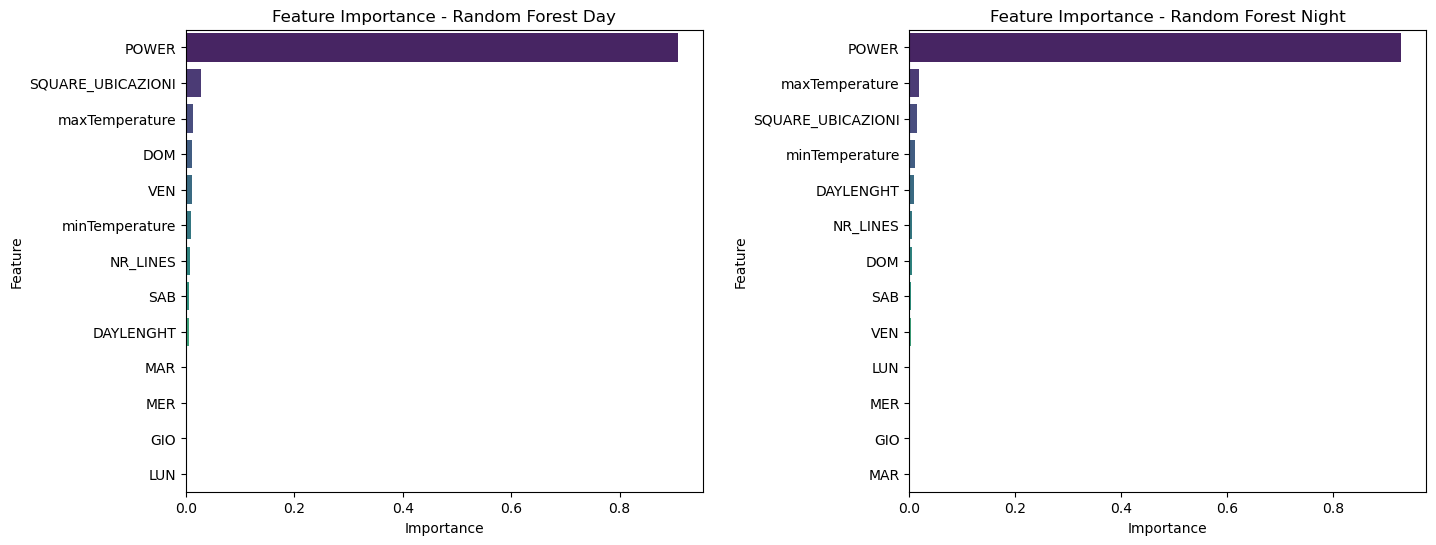

In [25]:
#Plotto i grafici a barre per day e night uno affianco all'altro 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#PLot per Giorno
sns.barplot(x='Importance', y='Feature', data=importance_df_day, order=importance_df_day['Feature'], palette='viridis', ax=ax1)
ax1.set_xlabel('Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Feature Importance - Random Forest Day')

#PLot per Notte
sns.barplot(x='Importance', y='Feature', data=importance_df_nig, order=importance_df_nig['Feature'], palette='viridis', ax=ax2)
ax2.set_xlabel('Importance')
ax2.set_ylabel('Feature')
ax2.set_title('Feature Importance - Random Forest Night')

#Regolo la distanza tra i due grafici
plt.subplots_adjust(wspace=0.4)

plt.show()

Da questi due grafici si può notare come le importanze cambino in maniera praticamente impercettibile tra fascia oraria diurna e notturna, questo solamente perchè la feature più importante è di gran lunga, ovviamente,'POWER'. Mi rassicura il fatto che non si basi affatto su un giorno della settimana perchè questo significa che non ha scoperto il mio escamotage di fargli predire la potenza del giorno successivo. Si fa presente comunque che si è provato ad utilizzare anche il metodo di train_test_split e il risultato delle importanze non variava, questo perchè la feature POWER è comunque quella maggiormente informativa per l'algoritmo il quale impara basandosi su di essa e non cercando strade altenative.

Calcolo quindi le previsioni del modello

In [26]:
#Calcolo le previsioni del modello

#Giorno
pred_rf_train_day = rf_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED']= pred_rf_train_day

pred_rf_test_day = rf_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED'] = pred_rf_test_day

#Notte
pred_rf_train_nig = rf_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED']= pred_rf_train_nig

pred_rf_test_nig = rf_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED'] = pred_rf_test_nig

In [27]:
#Faccio una funzione che mi valuti r2 e mse dei regressori che la utilizzerò spesso
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("Coefficient of Determination (R2):", r2)
    
    return mse, r2

Valuto i modelli trovati per le due fasce orarie tramite l'utilizzo dello scarto quadratico medio mse e il coefficiente di determinazione r2

In [28]:
#Giorno
mse_rf_test_day, r2_rf_test_day =evaluate_regression(y_test_day, pred_rf_test_day)
mse_rf_train_day, r2_rf_train_day = evaluate_regression(y_train_day, pred_rf_train_day)

Mean Squared Error (MSE): 10.238499357366281
Coefficient of Determination (R2): 0.9213949125041064
Mean Squared Error (MSE): 1.0472043101981352
Coefficient of Determination (R2): 0.9921453615240305


In [29]:
#Notte
mse_rf_test_nig, r2_rf_test_nig =evaluate_regression(y_test_nig, pred_rf_test_nig)
mse_rf_train_nig, r2_rf_train_nig = evaluate_regression(y_train_nig, pred_rf_train_nig)

Mean Squared Error (MSE): 7.633001156329876
Coefficient of Determination (R2): 0.9128942893156646
Mean Squared Error (MSE): 0.913175336534819
Coefficient of Determination (R2): 0.9894724928081406


DA RIVERE SE FEDE FA VEDERE IL GRAFICO DELLE POTENZE AL VARIARE DELL'ORA

Si notano in generale, che sia nel test che nel train degli orari notturni il risultato sia migliore, non di tanto ma è una differenza che comunque potrebbe non essere casuale. Si potrebbe pensare, avendo in mente il grafico delle potenze durante le diverse ore, che questo possa essere correlato al fatto che durante il giorno è più facile abbia cali e picchi di energia tra un giorno e l'altro, basti pensare che si accendono e si spengono le luci di mattina quando ormai il Sole illumina abbastanza e di sera quando il Sole è ormai tramontato, entrambi i casi (guardando i dati di Dawn e Sunset nel dataset iniziale) rientrano nella fascia oraria 8-19 all'incirca (l'alba avviene prima delle 8 ma la luce nornalmente non è abbastanza forte fino alle 8 circa). Questo significa che se ci sono nuvole o piove la Luce è necessaria di giorno quando il Sole dovrebbe esserci, mentre di notte le luci sono sempre accese a prescindere dal giorno del calendario. Questo quindi può provocare una differenza elevata tra la potenza media richiesta in una squareid da un giorno all'altro. Quindi si potrebbe ioootizzare che le random forest riescano a seguire un buon andamento delle potenze ma cambi troppo repentini da un giorno al successivo sembrano sfuggirgli di mano. Vedremmo se le nostre ipotesi verranno confermate più avanti

In generale comunque si nota che i risultati sono praticamente perfetti sul train mentre si nota una percentuale di errore più marcata sul test, sembra quindi che ci il modello stia facendo un po' di overfitting. Provo a rimediare usando GridSearchCV.

GridSearchCV esegue una ricerca esaustiva su una griglia di parametri specificati e valuta le prestazioni del modello per ogni combinazione di parametri. Questo permette di trovare la combinazione di iperparametri che massimizza le metriche di valutazione specificate come MSE o R^2.

L'utilizzo di GridSearchCV comporta i seguenti passaggi principali:

1. Definizione del modello di machine learning che si desidera ottimizzare, specificando gli iperparametri da cercare.

2. Definizione di una griglia di valori per ogni iperparametro che si desidera ottimizzare. È possibile specificare valori discreti, intervalli o distribuzioni.

3. Creazione di un oggetto GridSearchCV fornendo il modello, la griglia di parametri e la metrica di valutazione desiderata.

4. Esecuzione della ricerca dei parametri utilizzando il metodo fit() dell'oggetto GridSearchCV sulla base dei dati di addestramento. Durante questa fase, vengono eseguite tutte le combinazioni dei parametri specificati e viene addestrato e valutato il modello per ciascuna combinazione.

5. Ottenimento dei migliori parametri e del miglior modello attraverso gli attributi best_params_ e best_estimator_ dell'oggetto GridSearchCV.

6. Valutazione delle prestazioni del modello ottimizzato sui dati di test o attraverso la cross-validazione interna effettuata durante la ricerca dei parametri.

GridSearchCV offre anche altre funzionalità, come la possibilità di specificare una strategia di cross-validation, il parallelismo per accelerare la ricerca dei parametri e l'accesso ai risultati completi della ricerca dei parametri.

In sintesi, GridSearchCV semplifica il processo di ricerca dei migliori iperparametri per un modello di machine learning, automatizzando la creazione di diverse combinazioni di parametri e la valutazione delle prestazioni del modello. Questo aiuta a migliorare le prestazioni del modello e a ottenere risultati ottimali per una data task di machine learning.


In [30]:
def train_regression_model(regressor, param_grid, cv, X, y):
    
    #OUTPUT: regressore ottimizzato con i parametri messi nella griglia di parametri param_grid
    
    #ANNOTAZIONI: X e y sono le X e le y del TRAIN perchè questa funzione mi fitta il regressore che voglio usare con i migliori
    #iperparametri che ho messo nella griglia di parametri param_grid.
    #'param_grid' è la griglia di parametri che deve essere definita come un dizionario quindi:
    #param_grid={
    #            "parametro_1": "[valore1, valore2, ...]",
    #            "parametro_2": "[valore1, valore2]",
    #             ...
    #            }
    #La funzione in outpunt mi restituisce il regressore ottimizzato quindi la devo chiamare così:
    # nome_regressore_ottimizzato = train_regression_model(regressore_da_ottimizzare, param_grid, ...)
    #Nota: il regressore migliore 'best_regressor' NON fitta sui punti, non è stata implementata quella riga di codice perchè
    #se i 'best_params' sono gli stessi tra un tentativo e l'altro quando cambio i parametri di param_grid non ha senso aspettaere
    #che mi faccia il fit, è lo stesso di prima già fatto
    
    
    grid_search = GridSearchCV(regressor, param_grid, cv=cv)
    grid_search.fit(X, y)

    #Printa i migliori parametri trovati
    best_params = grid_search.best_params_
    print("Migliori parametri:", best_params)

    
    best_regressor = regressor.__class__(**best_params) #Crea un nuovo regressore con i migliori parametri
    
    
    return best_regressor, best_params

Gli iperparametri che andiamo ad utilizzare sono:

- n_estimators: rappresenta il numero di alberi nella foresta. È possibile specificare un valore intero che indica il numero desiderato di alberi. Più alberi possono migliorare la capacità di generalizzazione del modello, ma aumentano anche il costo computazionale.

- max_depth: specifica la massima profondità di ciascun albero nella foresta. È possibile fornire un valore intero per limitare la profondità degli alberi. Limitare la profondità può aiutare a prevenire l'overfitting, ma potrebbe anche ridurre la capacità del modello di catturare relazioni complesse nei dati.

- min_samples_split: rappresenta il numero minimo di campioni richiesti per dividere un nodo interno dell'albero. È possibile specificare un valore intero o un float che indica una proporzione dei campioni totali. Aumentare questo valore può ridurre il rischio di overfitting.

- min_samples_leaf: specifica il numero minimo di campioni richiesti in una foglia dell'albero. È possibile fornire un valore intero o un float che indica una proporzione dei campioni totali come per l'iperparametro precedente. Aumentare questo valore può ridurre il rischio di overfitting, ma potrebbe anche ridurre la sensibilità del modello alle variazioni nei dati.

- min_impurity_decrease: rappresenta una soglia per ridurre l'impurità richiesta per eseguire una divisione. È possibile specificare un valore float che indica la riduzione minima dell'impurità. Aumentare questo valore può semplificare la struttura dell'albero e ridurre l'overfitting.

Questi iperparametri possono essere utilizzati per controllare il comportamento e la complessità del modello RandomForestRegressor e per ottimizzare le prestazioni in base alle specifiche esigenze del problema.


A causa di necessità computazionali e per il fatto che per 3 tentativi di una griglia di parametri diversa min_impurity_decrease mi ha sempre restituito per entrambe le fasce orarie valore uguale a 0.0, si commenta dalla griglia di parametri per risparmiare tempo

In [ ]:
regressor_day = RandomForestRegressor()
regressor_nig = RandomForestRegressor()
param_grid = {
    "n_estimators": [50, 100, 150],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2],
    "max_depth": [5, 7, 10], 
    #"min_impurity_decrease": [0.0, 0.01, 0.001], rallenta troppo la ricerca e non sembra dare alcun risultato initeressante
} 

Utilizzo la stessa griglia di parametri tra day e night perchè non mi aspetto di dover ottimizzare in maniera completamente
diversa avendo comunque risultati abbastanza simili

In [ ]:
rf_best_day, best_params_day = train_regression_model(regressor_day, param_grid, 5, x_train_day, y_train_day)

In [ ]:
rf_best_nig, best_params_nig = train_regression_model(regressor_nig, param_grid, 5, x_train_nig, y_train_day)

Il tempo che ci mette per usare la gridsearch è comunque troppo elevato quindi si cerca di fare prove con altri parametri impostandoli "manualmente" (per questo le due celle qui sopra sono state runnate molto prima rispetto a quelle nel loro intorno). Provando in questo modo si troveranno combinazioni migliori e quindi ci si baserà su quelle

Ottimizzo il regressore nella speranza di allenarlo a generalizzare maggiormente e commettere quindi meno overfitting aggiungendo i seguenti parametri:

- criterion: "criterion" specifica la funzione di misura della qualità della divisione durante la costruzione degli alberi dell'ensemble. Si può impostare su "mse" (Mean Squared Error) viene utilizzato per valutare la qualità delle divisioni oppure su "mae" (Mean Absolute Error) per utilizzare l'errore assoluto medio come criterio di divisione.

- bootstrap: "bootstrap" indica se viene eseguito il campionamento bootstrap durante la costruzione di ciascun albero. Il campionamento bootstrap consiste nel prendere un campione casuale con sostituzione dal set di addestramento per costruire ciascun albero.

In [48]:
# Crea un nuovo regressore con i migliori parametri
rf_grid_day = RandomForestRegressor(n_estimators=150, max_depth=12, min_samples_leaf = 1, min_samples_split = 2,
                                    bootstrap=True, criterion='mse')
rf_grid_nig = RandomForestRegressor(n_estimators=170, max_depth=13, min_samples_leaf=1, min_samples_split=3,
                                    bootstrap=True, criterion='mse')

In [49]:
# Addestra il regressore sui dati di addestramento
rf_grid_day.fit(x_train_day, y_train_day)
rf_grid_nig.fit(x_train_nig, y_train_nig)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=170, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
#Predizioni del modello RF ottimizzato 

#Giorno 
pred_rf_grid_train_day = rf_grid_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_GRID']= pred_rf_grid_train_day

pred_rf_grid_test_day = rf_grid_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_GRID'] = pred_rf_grid_test_day

#Notte
pred_rf_grid_train_nig = rf_grid_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_GRID']= pred_rf_grid_train_nig

pred_rf_grid_test_nig = rf_grid_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_GRID'] = pred_rf_grid_test_nig


In [46]:
#Valuto i modelli ottimizzati di day e night

#Giorno
mse_rf_grid_test_day, r2_rf_grid_test_day =evaluate_regression(y_test_day, pred_rf_grid_test_day)
mse_rf_grid_train_day, r2_rf_grid_train_day = evaluate_regression(y_train_day, pred_rf_grid_train_day)

Mean Squared Error (MSE): 9.851594962830408
Coefficient of Determination (R2): 0.9243653335319847
Mean Squared Error (MSE): 2.0749189783144746
Coefficient of Determination (R2): 0.9844369066447936


In [47]:
#Notte
mse_rf_grid_test_nig, r2_rf_grid_test_nig =evaluate_regression(y_test_nig, pred_rf_grid_test_nig)
mse_rf_grid_train_nig, r2_rf_grid_train_nig = evaluate_regression(y_train_nig, pred_rf_grid_train_nig)

Mean Squared Error (MSE): 7.461588875288378
Coefficient of Determination (R2): 0.9148503991411899
Mean Squared Error (MSE): 1.216328790750438
Coefficient of Determination (R2): 0.9859775997226546


Viene limitato l'overfitting ma comunque non si riscontrano eccessivi miglioramenti rispetto al modello in cui non ho ottimizzato i 4 iperparametri più importanti. Si riportano comunque entrambi i risultati successivamente per completezza e per avere un effetto visivo meggiore nel capire quanto siano simili come modelli 

Si nota come ci si aspettva sempre e comunque un MSE maggiore nelle fasce diurne piuttosto che quelle notturne, non solo perchè mi aspetto una maggior varianza in generale ma anche percè le potenze saranno più elevate e quindi una previsione con R^2 simile mi dà un errore maggiore in valore assoluto tra le potenze perchè si ragiona a valori centrali maggiori. Per questo è presente questa differenza in MSE pur avendo un R^2 molto simile (addirittura leggermente maggiore per la fascia diurna)

Provo a plottare un grafico sui giorni per i singoli squareid 

In [51]:
#Riordino gli indici della prima colonna (quella senza nome messa da Pandas) perchè sennò con il concat ho errore

#Giorno
x_train_square_day = x_train_square_day.reset_index(drop=True)
x_test_square_day = x_test_square_day.reset_index(drop=True)

#Notte
x_train_square_nig = x_train_square_nig.reset_index(drop=True)
x_test_square_nig = x_test_square_nig.reset_index(drop=True)


In [52]:
#Rimetto insieme il dataset delle x su cui si basa la predizione del target e le y cioè il target, sia nel train che nel test

#Giorno
train_pred_day = pd.concat([x_train_square_day, pd.DataFrame(y_train_day)], axis=1) #axis=1 mi fa unire i dataframe uno affianco
test_pred_day = pd.concat([x_test_square_day, pd.DataFrame(y_test_day)], axis=1) #all'altro e non uso sotto l'altro 

#Notte
train_pred_nig = pd.concat([x_train_square_nig, pd.DataFrame(y_train_nig)], axis=1)
test_pred_nig = pd.concat([x_test_square_nig, pd.DataFrame(y_test_nig)], axis=1)

In [53]:
#Definisco la lista delle colonne dei dataframe appena creati nella cella precedente perchè devo/voglio cambiare il nome della 
#nuova colonna immessa che sennò viene chiamata '0'

#Giorno
columns_tr_day = train_pred_day.columns.to_list()
columns_ts_day =test_pred_day.columns.to_list()

#Notte
columns_tr_nig = train_pred_nig.columns.to_list()
columns_ts_nig =test_pred_nig.columns.to_list()

In [54]:
#Cambio il nome dell'ultima colonna in 'POW_TO_PRED' cioè come l'avevo chiamata inizialmente

#Giorno
columns_tr_day[-1] = 'POW_TO_PRED'
columns_ts_day[-1] = 'POW_TO_PRED'

train_pred_day.columns = columns_tr_day #Aggiorno i nomi delle colonne nel DataFrame
test_pred_day.columns = columns_ts_day

#Notte
columns_tr_nig[-1] = 'POW_TO_PRED'
columns_ts_nig[-1] = 'POW_TO_PRED'

train_pred_nig.columns = columns_tr_nig
test_pred_nig.columns = columns_ts_nig

In [55]:
#Metto insieme test e train 

#Giorno
predictions_day = pd.concat([train_pred_day, test_pred_day], axis=0)

#Notte
predictions_nig = pd.concat([train_pred_nig, test_pred_nig], axis=0)

In [56]:
#Riordino il dataframe delle predizioni in base a squareid e day per avere riscontro sul dataframe iniziale, per avere conferma
#di non aver commesso qualche errore con i concat

#Giorno
predictions_day = predictions_day.sort_values(['SQUAREID', 'DAY'])

#Notte
predictions_nig = predictions_nig.sort_values(['SQUAREID', 'DAY'])

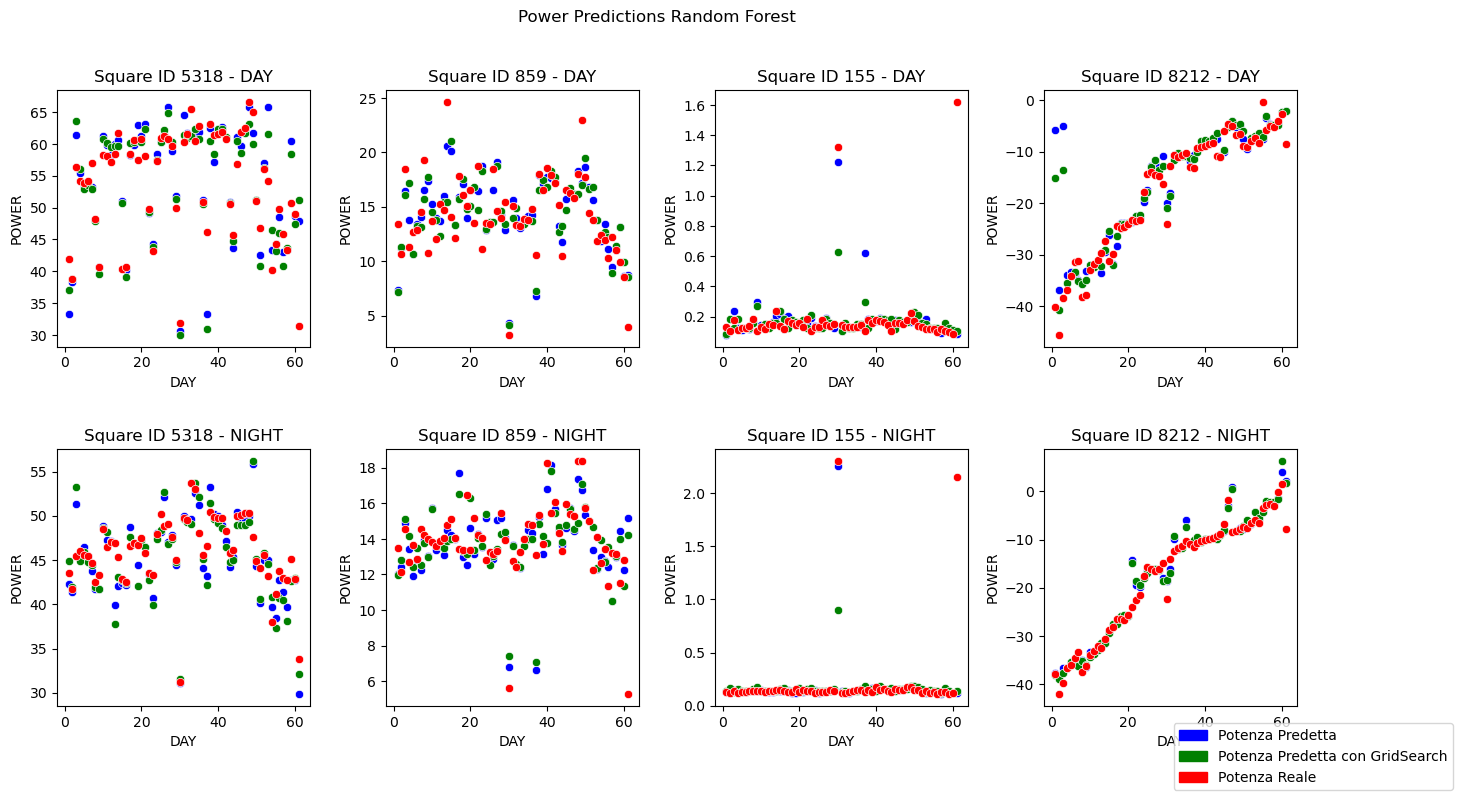

In [57]:
import matplotlib.patches as mpatches

#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5318, 859, 155, 8212]

# Creazione dei subplots per i grafici
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Power Predictions Random Forest')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta con GridSearch')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

# Aggiunta della legenda unica
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

# Regola lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Mostra i plot
plt.show()




Sono riportati i grafici sia per la fascia oraria di giorno che per quella di notte per i quattro square_id che sono ritenuti maggiormente rappresentativi della potenza in cui si può ritenere lo square_id 5318 una cella in cui si ha elevato consumo energetico, lo square_id 859 rappresenta un consumo medio, il 155 invece rappresenta un consumo basso (con l'aggiunta di due "picchi" tra l'inizio e la fine di dicembre dove si può osservare come si comporta il mio algoritmo di fronte a varianze così elevate improssive e "casuali") e 8212 invece rappresenta uno square id dove ho consumo negativo (quindi dove viene immessa più energia nelle rete elettrica di quanta non se ne usi).

Si nota come già preventivato che il modello ottimizzato e quello non ottimizzato siano molto simili, riescano a predire abbastanza bene l'andamento di tutti i possibili range di potenza individuati sia durante la notte che durante il giorno (unico punto dove si vede grande differenza è in squareid 155 di notte ma parliamo di 1 kW quindi distanza in linea con i valori di R^2 e MSE trovati in precedenza). Entrambi i modelli fanno fatica a prevedere sbalzi di potenza molto grandi da un giorno all'altro come si può notare bene nello squareid 155 cove ci sono 2 giorni (uno verso fine dicembre e l'altor verso l'inizio) in cui la potenza richiesta è molto più elevata rispetto a quella degli altri giorni (è 8 volte maggiore ma non si intende che sia elevata in valore assoluto) e i due modelli in quei casi sbagliano molto (ci va vicino durante la notte il modello senza gridsearch per il dato di inizio dicembre come già detto); oppure in generale nello squareid 5318 dove le potenze tra i giorni hanno sbalzi anche di 20kW. Mentre sono molto precisi nei casi in cui c'è poca varianza come si può vedere bene dallo squareid 8212

Come si era previsto il modello riesce ad avere un riscontro visivo migliore (che conferma i migliori valori di MSE e R^2) nella fascia oraria notturna piuttosto che in quella diurna proprio per il motivo citato in precedenza: tra i diversi giorni è più facile che abbia cambi di potenza significativi rispetto alla fascia notturna dove normalmente l'andamento normalmente è più stabile. Come si poteva notare infatti per la fascia diurna ho un MSE molto maggiore, notando che il modello fa più fatica a prevedere grandi sbalzi di energia era prevedibile che perfomasse meglio nelle ore notturne

## XGBoost

Provo ad utilizzare XGBoost essendo un algoritmo più potente il quale potrebbe darmi risultati migliori, anche se comunque i risultati appena riscontrati e discussi sono già ad un livello più che accettabile avendo uno scarto quadratico medio (mse) minore delle decine, intorno a 9-10 per la predizione sul test in entrambe le fasce orarie

Piccola introduzione a XGBoost:

XGBoost (eXtreme Gradient Boosting) è un framework di machine learning che si basa sul boosting al fine di creare un modello di regressione potente e preciso. Il boosting è una tecnica di apprendimento automatico che combina diversi modelli deboli, come ad esempio alberi decisionali semplici, in un unico modello più robusto e accurato. A differenza di un singolo modello forte, che potrebbe essere complesso e soggetto a overfitting, il boosting sfrutta l'insieme dei modelli deboli, chiamati anche "weak learner", per compensare le loro limitazioni individuali e migliorare le prestazioni complessive del modello.

Il processo di boosting si svolge in iterazioni, in cui vengono addestrati i modelli deboli in sequenza, mettendo un'attenzione maggiore sugli esempi di addestramento che sono stati classificati erroneamente o per cui il modello ha commesso un errore. Ogni modello debolmente addestrato cerca di correggere gli errori commessi dai modelli precedenti, concentrandosi sugli esempi più difficili. L'output finale è una combinazione pesata dei modelli deboli, in cui i pesi sono assegnati in base alla loro competenza nel risolvere specifiche istanze di addestramento.

Il modello XGBoostRegressor presenta diverse caratteristiche e iperparametri che possono essere regolati per ottimizzare le prestazioni del modello e di cui poi faremo uso quindi introduco gli iperparametri importanti che verranno considerati:

- Iperparametri: Alcuni dei principali iperparametri che possono essere regolati includono:

    - learning_rate: Controlla la velocità di apprendimento del modello. Un learning rate più basso rende il modello più conservativo, mentre un learning rate più alto può portare a un addestramento più veloce ma potenzialmente meno preciso.
    
    - n_estimators: Specifica il numero di alberi decisionali da addestrare. Un valore più alto può aumentare la complessità del modello, ma potrebbe richiedere più tempo di addestramento.
    
    - max_depth: Limita la profondità massima di ciascun albero decisionale. Impostare un valore più basso può aiutare a prevenire l'overfitting, ma potrebbe ridurre la capacità del modello di catturare pattern complessi.
    
    - min_child_weight: Specifica la somma minima dei pesi delle istanze richiesta in un nodo per continuare la suddivisione. Un valore più alto promuove la conservazione dei nodi più grandi e può ridurre l'overfitting.
    
    - gamma: Specifica la riduzione minima richiesta della funzione di costo per eseguire una suddivisione. Un valore più alto aumenta la regolarizzazione del modello.
- Regolarizzazione: XGBoostRegressor offre diverse tecniche di regolarizzazione per prevenire l'overfitting e migliorare la generalizzazione del modello. Alcuni dei principali iperparametri di regolarizzazione includono:

    - reg_alpha e reg_lambda: Specificano i termini di regolarizzazione L1 e L2, rispettivamente, per controllare la complessità del modello e limitare il peso dei coefficienti delle caratteristiche.
    - subsample: Specificano la frazione di campioni e caratteristiche da utilizzare in ciascuna iterazione di addestramento, consentendo di eseguire il campionamento stocastico.

In [58]:
xgb_regressor_day = XGBRegressor()
xgb_regressor_nig = XGBRegressor()

In [66]:
xgb_regressor_day.fit(x_train_day, y_train_day)
xgb_regressor_nig.fit(x_train_nig, y_train_nig)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

In [67]:
#Mi trovo le importanze delle features di Random Forest

#Giorno
feature_importances_xgb_day = xgb_regressor_day.feature_importances_ 
#Notte
feature_importances_xgb_nig = xgb_regressor_nig.feature_importances_

In [68]:
#Giorno
importance_df_xgb_day = pd.DataFrame({'Feature': x_train_day.columns, 'Importance': feature_importances_xgb_day}) #creo dataframe delle importanze
importance_df_xgb_day = importance_df_xgb_day.sort_values(by='Importance', ascending=False) #ordino le features dalla più importante alla meno

#Notte 
importance_df_xgb_nig = pd.DataFrame({'Feature': x_train_nig.columns, 'Importance': feature_importances_xgb_nig}) 
importance_df_xgb_nig = importance_df_xgb_nig.sort_values(by='Importance', ascending=False)

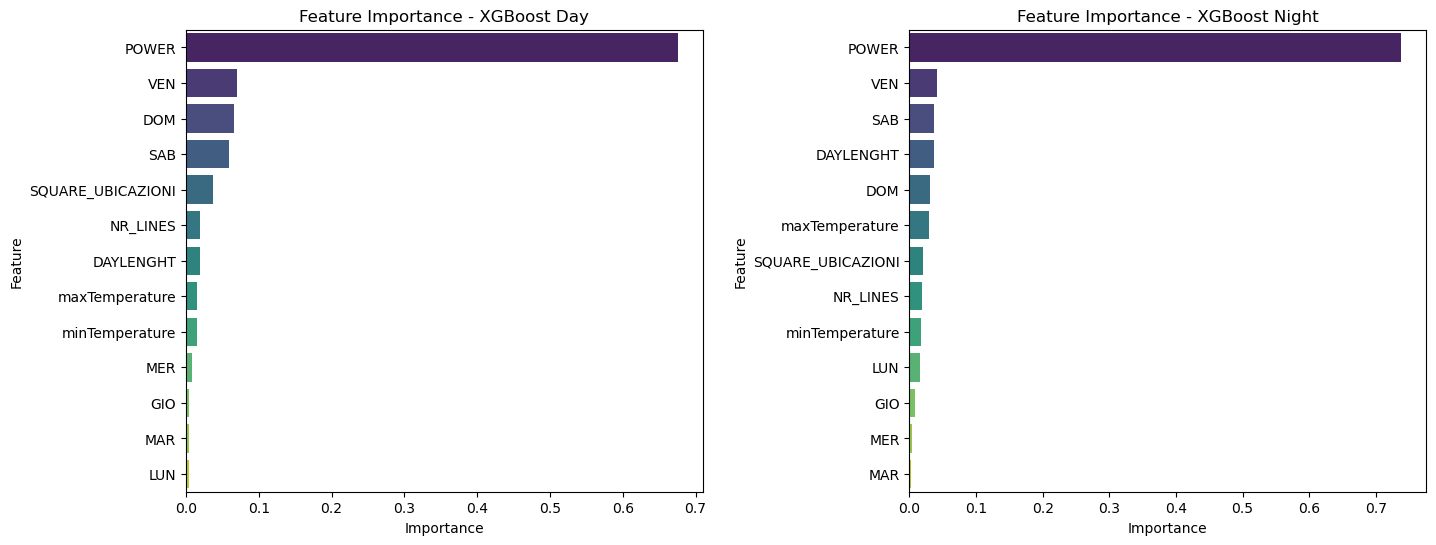

In [69]:
#Plotto i grafici a barre per day e night uno affianco all'altro 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#PLot per Giorno
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb_day, order=importance_df_xgb_day['Feature'], palette='viridis', ax=ax1)
ax1.set_xlabel('Importance')
ax1.set_ylabel('Feature')
ax1.set_title('Feature Importance - XGBoost Day')

#PLot per Notte
sns.barplot(x='Importance', y='Feature', data=importance_df_xgb_nig, order=importance_df_xgb_nig['Feature'], palette='viridis', ax=ax2)
ax2.set_xlabel('Importance')
ax2.set_ylabel('Feature')
ax2.set_title('Feature Importance - XGBoost Night')

#Regolo la distanza tra i due grafici
plt.subplots_adjust(wspace=0.4)

plt.show()

Si nota come le importanze delle features sono leggermente diverse da quelle del modello di random forest in cui venerdì sabato e domenica sembrano avere un maggiore impatto, questo probabilmente perchè durante il weekend il consumo energetico è nettamente minore rispetto ai giorni infrasettimanali e XGBoost è più sensibile a questa informazione (per il concetto di boosting spiegato sopra). Per questo motivo, si era pensato che con XGBoost l'accortezza di come abbiamo diviso train e test fosse altamente necessaria ma si è provato anche con train_test_split e il risultato non cambiava come nel caso delle Random Forest

In [70]:
#Calcolo predizioni di XGBoost su train e test

#Giorno
pred_xgb_train_day = xgb_regressor_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_XGB']= pred_xgb_train_day #creo nuova colonna sui dati iniziali che rappresenta la predizione di
#XGBoost per avere un dataframe probabilmente più utile poi per fare qualche grafico

pred_xgb_test_day = xgb_regressor_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_XGB'] = pred_xgb_test_day 

#Notte
pred_xgb_train_nig = xgb_regressor_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_XGB']= pred_xgb_train_nig

pred_xgb_test_nig = xgb_regressor_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_XGB'] = pred_xgb_test_nig

In [71]:
#Valuto r2 e mse per test e train

#Giorno
mse_xgb_test_day, r2_xgb_test_day = evaluate_regression(y_test_day, pred_xgb_test_day)
mse_xgb_train_day, r2_xgb_train_day = evaluate_regression(y_train_day, pred_xgb_train_day)

Mean Squared Error (MSE): 10.756335293308823
Coefficient of Determination (R2): 0.9174192772442384
Mean Squared Error (MSE): 1.7725352144812299
Coefficient of Determination (R2): 0.9867049599012433


In [72]:
#Notte
mse_xgb_test_nig, r2_xgb_test_nig = evaluate_regression(y_test_nig, pred_xgb_test_nig)
mse_xgb_train_nig, r2_xgb_train_nig = evaluate_regression(y_train_nig, pred_xgb_train_nig)

Mean Squared Error (MSE): 8.351897805073609
Coefficient of Determination (R2): 0.9046904384036967
Mean Squared Error (MSE): 1.2970662690097374
Coefficient of Determination (R2): 0.9850468207703313


Un modello con XGBoost senza alcun parametro mi fa ottenere valori minori di R^2 rispetto a quelli di Randomm Forest, provo a migliorare il fit tramite la GridSearch.

Si nota comunque che anche in questo caso abbia un valore di R^2 migliore per la fascia diurna ma ho MSE maggiore, per lo stesso discorso fatto in precedenza con il modello di Random Forest

Provo a migliorare l'XGBoost con la GridSearchCV  

In [ ]:
# NON RUNNARE CI METTE TROPPO

regressor_day = XGBRegressor()
regressor_nig = XGBRegressor()

param_grid = {
    "learning_rate": [0.14, 0.15, 0.16],#Velocità di apprendimento del singolo albero
    "n_estimators": [70, 73, 75],
    "max_depth": [9, 10, 11],
    "min_child_weight": [1, 5, 10], #Peso minimo richiesto per creare un nuovo nodo dell'albero durante la crescita
    "gamma": [0.1, 0.5, 1], #Rappresenta il parametro di riduzione della perdita per la potatura degli alberi
    "subsample": [0.5, 1], # Rappresenta la frazione di campioni utilizzati per addestrare ciascun albero
    "reg_lamda": [0.0, 0.1, 0.001] #Pensalità di regolarizzazione L2
    "reg_alpha": [0.0, 0.1, 0.001] #Pensalità di regolarizzazione L1
}

In [ ]:
#NON RUNNARE CI METTE TROPPO

xgb_best_day = train_regression_model(regressor, param_grid, 5, x_train_day, y_train_day)
xgb_best_nig = train_regression_model(regressor, param_grid, 5, x_train_nig, y_train_nig)

Purtroppo a causa di tempi computazionali anche se mettessi solamente 4 parametri la gridsearch con un algoritmo così complesso mi causa tempi di risposta per gli iperparametri di più di 6 ore per fascia oraria quindi cerco di ottimizzare il modello cercando "a mano" la combinazione migliore, rinunciando ad una ricerca più sistematica ma andando ad intuito cercando di cogliere le risposte del modello al variare dei parametri

In [88]:
#Ci mette troppo quindi uso dei parametri che sono riuscito a trovare qualche giorno fa
xgb_grid_day = XGBRegressor(gamma=0.8, learning_rate=0.12, max_depth=7, min_child_weight=2, n_estimators=80, subsample=1,
                            reg_lamda=0.001, reg_alpha=0.001)
xgb_grid_nig = XGBRegressor(gamma=0.9, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=100, subsample=0.9,
                            reg_lamda=0.001, reg_alpha=0.001)

In [89]:
#Addestro i due XGB
xgb_grid_day.fit(x_train_day, y_train_day)
xgb_grid_nig.fit(x_train_nig, y_train_nig)

[12:45:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_lamda" } are not used.

[12:45:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "reg_lamda" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.9, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)

In [90]:
#Predizioni del modello XGB ottimizzato 

#Giorno 
pred_xgb_grid_train_day = xgb_grid_day.predict(x_train_day)
x_train_square_day.loc[:, 'POW_PRED_XGB_GRID']= pred_xgb_grid_train_day

pred_xgb_grid_test_day = xgb_grid_day.predict(x_test_day)
x_test_square_day.loc[:, 'POW_PRED_XGB_GRID'] = pred_xgb_grid_test_day

#Notte
pred_xgb_grid_train_nig = xgb_grid_nig.predict(x_train_nig)
x_train_square_nig.loc[:, 'POW_PRED_XGB_GRID']= pred_xgb_grid_train_nig

pred_xgb_grid_test_nig = xgb_grid_nig.predict(x_test_nig)
x_test_square_nig.loc[:, 'POW_PRED_XGB_GRID'] = pred_xgb_grid_test_nig


In [91]:
#Valuto i modelli ottimizzati di day e night

#Giorno
mse_xgb_grid_test_day, r2_xgb_grid_test_day = evaluate_regression(y_test_day, pred_xgb_grid_test_day)
mse_xgb_grid_train_day, r2_xgb_grid_train_day = evaluate_regression(y_train_day, pred_xgb_grid_train_day)

Mean Squared Error (MSE): 9.98232696629726
Coefficient of Determination (R2): 0.9233616512332079
Mean Squared Error (MSE): 2.7161624100222297
Coefficient of Determination (R2): 0.979627209738369


In [92]:
#Notte
mse_xgb_grid_test_nig, r2_xgb_grid_test_nig =evaluate_regression(y_test_nig, pred_xgb_grid_test_nig)
mse_xgb_grid_train_nig, r2_xgb_grid_train_nig = evaluate_regression(y_train_nig, pred_xgb_grid_train_nig)

Mean Squared Error (MSE): 7.4540328249269985
Coefficient of Determination (R2): 0.9149366267105581
Mean Squared Error (MSE): 1.932253747819698
Coefficient of Determination (R2): 0.9777240860404103


Con l'ottimizzazione tramite si è riusciti a trovare un buon risultato, non in maniera trascendentale ma i risultati sono migliori. Si nota come in questo caso la fascia notturna sia migliorata a tal punto da essere di nuovo la fascia leggermente meglio prevista e sia gli errori sul test che sul train sono simili tra le due fasce mantenendo comunque quell'intrinseca differenza dovuta al fatto che in 8-19 l'energia consumata sia nettamente maggiore, però sul train ho un valore leggermente maggiore di MSE (poco meno di 1 unità) rispetto al caso di Random Forest che, anche se molto piccolo, viene comunque segnalato. Questo potrebbe portare il regressore a performare leggermente meglio sull'insieme di test. Il confronto comunque avverrà alla fine del notebook

Si nota in generale come, sia Random Forest che XGBoost riescano ad essere più performantii sulla fascia oraria diurna che quella notturna, seppur di poco

Ora creo un grafico con i due modelli di XGBoost (ottimizzato e non) per cercare una valutazione più visiva della correttezza o meno dei modelli anche se non mi aspetto differenze abissali come già detto

In [93]:
#Riordino gli indici della prima colonna (quella senza nome messa da Pandas) perchè sennò con il concat ho errore

#Giorno
x_train_square_day = x_train_square_day.reset_index(drop=True)
x_test_square_day = x_test_square_day.reset_index(drop=True)

#Notte
x_train_square_nig = x_train_square_nig.reset_index(drop=True)
x_test_square_nig = x_test_square_nig.reset_index(drop=True)


In [94]:
#Rimetto insieme il dataset delle x su cui si basa la predizione del target e le y cioè il target, sia nel train che nel test

#Giorno
train_pred_day = pd.concat([x_train_square_day, pd.DataFrame(y_train_day)], axis=1) #axis=1 mi fa unire i dataframe uno affianco
test_pred_day = pd.concat([x_test_square_day, pd.DataFrame(y_test_day)], axis=1) #all'altro e non uso sotto l'altro 

#Notte
train_pred_nig = pd.concat([x_train_square_nig, pd.DataFrame(y_train_nig)], axis=1)
test_pred_nig = pd.concat([x_test_square_nig, pd.DataFrame(y_test_nig)], axis=1)

In [95]:
#Definisco la lista delle colonne dei dataframe appena creati nella cella precedente perchè devo/voglio cambiare il nome della 
#nuova colonna immessa che sennò viene chiamata '0'

#Giorno
columns_tr_day = train_pred_day.columns.to_list()
columns_ts_day =test_pred_day.columns.to_list()

#Notte
columns_tr_nig = train_pred_nig.columns.to_list()
columns_ts_nig =test_pred_nig.columns.to_list()

In [96]:
#Cambio il nome dell'ultima colonna in 'POW_TO_PRED' cioè come l'avevo chiamata inizialmente

#Giorno
columns_tr_day[-1] = 'POW_TO_PRED'
columns_ts_day[-1] = 'POW_TO_PRED'

train_pred_day.columns = columns_tr_day #Aggiorno i nomi delle colonne nel DataFrame
test_pred_day.columns = columns_ts_day

#Notte
columns_tr_nig[-1] = 'POW_TO_PRED'
columns_ts_nig[-1] = 'POW_TO_PRED'

train_pred_nig.columns = columns_tr_nig
test_pred_nig.columns = columns_ts_nig

In [97]:
#Metto insieme test e train 

#Giorno
predictions_day = pd.concat([train_pred_day, test_pred_day], axis=0)

#Notte
predictions_nig = pd.concat([train_pred_nig, test_pred_nig], axis=0)

In [98]:
#Riordino il dataframe delle predizioni in base a squareid e day per avere riscontro sul dataframe iniziale, per avere conferma
#di non aver commesso qualche errore con i concat

#Giorno
predictions_day = predictions_day.sort_values(['SQUAREID', 'DAY'])

#Notte
predictions_nig = predictions_nig.sort_values(['SQUAREID', 'DAY'])

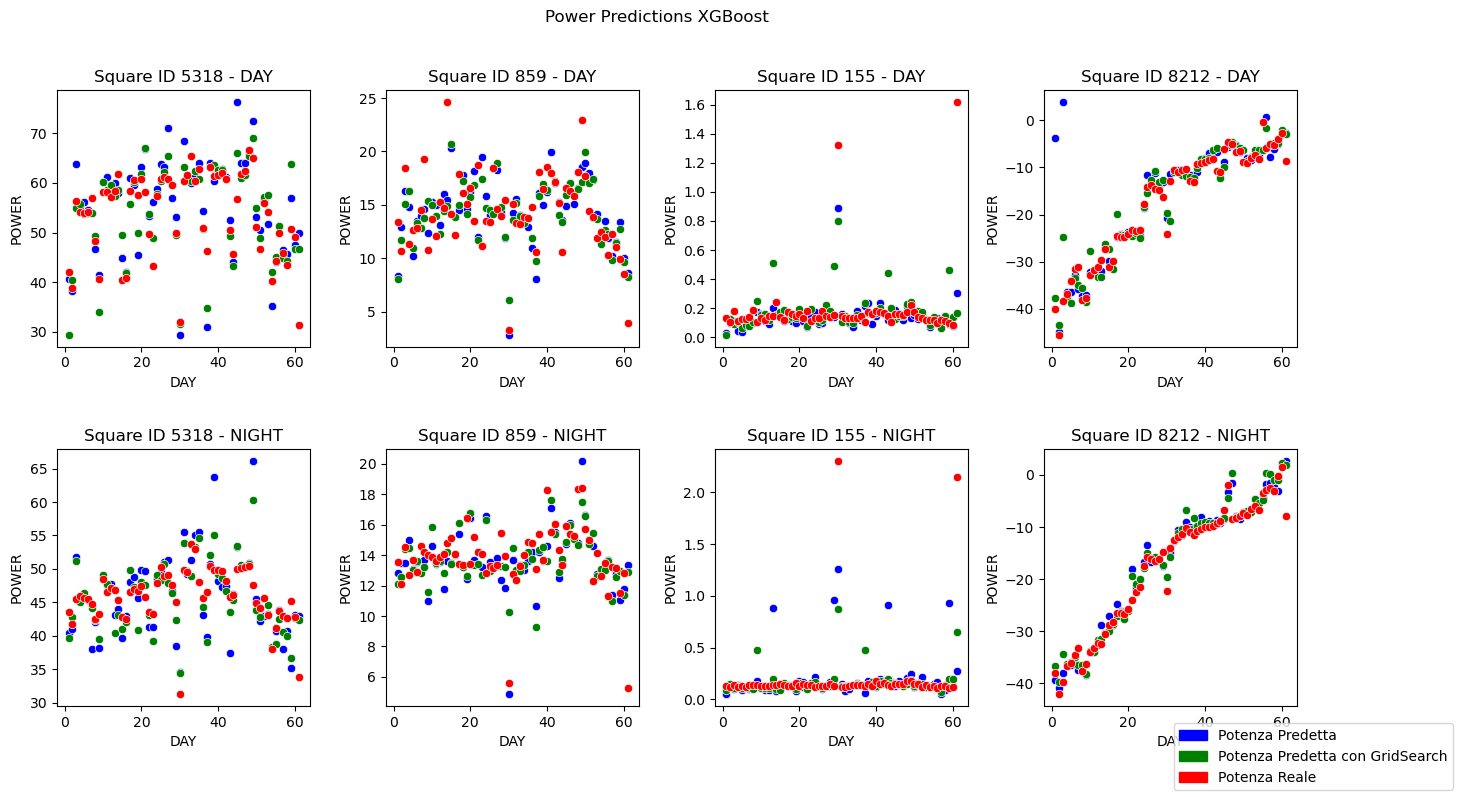

In [99]:
#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5318, 859, 155, 8212]

#Creo subplot per Giorno e Notte
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Power Predictions XGBoost')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta con GridSearch')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

#Aggiungo la legenda unica così da occupare meno spazio
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

#Regolo lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()


Si vede, come previsto, che il modello ottimizzato non si discosti più di tanto da quello non ottimizzato che però si può percepepire come migliore soprattutto nella fascia notturna (guardando lo squareid 155). Anche nel caso di XGBoost, come con le Random Forest, si trova maggior difficoltà a prevedere la potenza quando c'è maggior varianza, questo probabilmente può essere dato sia da un possibile limite dell'algoritmo o dei dati che gli passiamo (forse non sufficienti a fornirlo di tutte le informazioni necessarie per informarlo al meglio) che quindi mi fa ottenere il risultato che cercare di prevedere una grande variazione da un giorno all'altro non sia fattibile al 100% perchè è dovuto a fatti che non sono catalogati nelle informazioni. Questo poteva far pensare che implementando nel train più giorni e cercando di prevedere quello successivo si potesse migliorare la situazione ma così non è stato anche in questo caso, per le stesse ragioni per il quale non ha avuto effetto sulla regressione lineare: perchè il modello si basa molto di più sulla potenza del giorno direttamente precedente rispetto a tutto il resto e quindi questa nuova features non era abbastanza importante da far cambiare il risultato delle previsioni. 

## Confronto tra il miglior modello RF e XGB

Ora cerchiamo un confronto grafico tra il modello con le Random Forest e quello estrapolato utilizzando XGBoost, anche se ci si aspetta che non ci siano grandi differenze visive poichè anche solo dagli score di r2 e mse è difficile notare grandi differenze per discriminare tra quale sia meglio o quale sia peggio. Si discutono in questo caso però solamente i modelli ottimizzati perchè migliori rispetto a quelli "base".

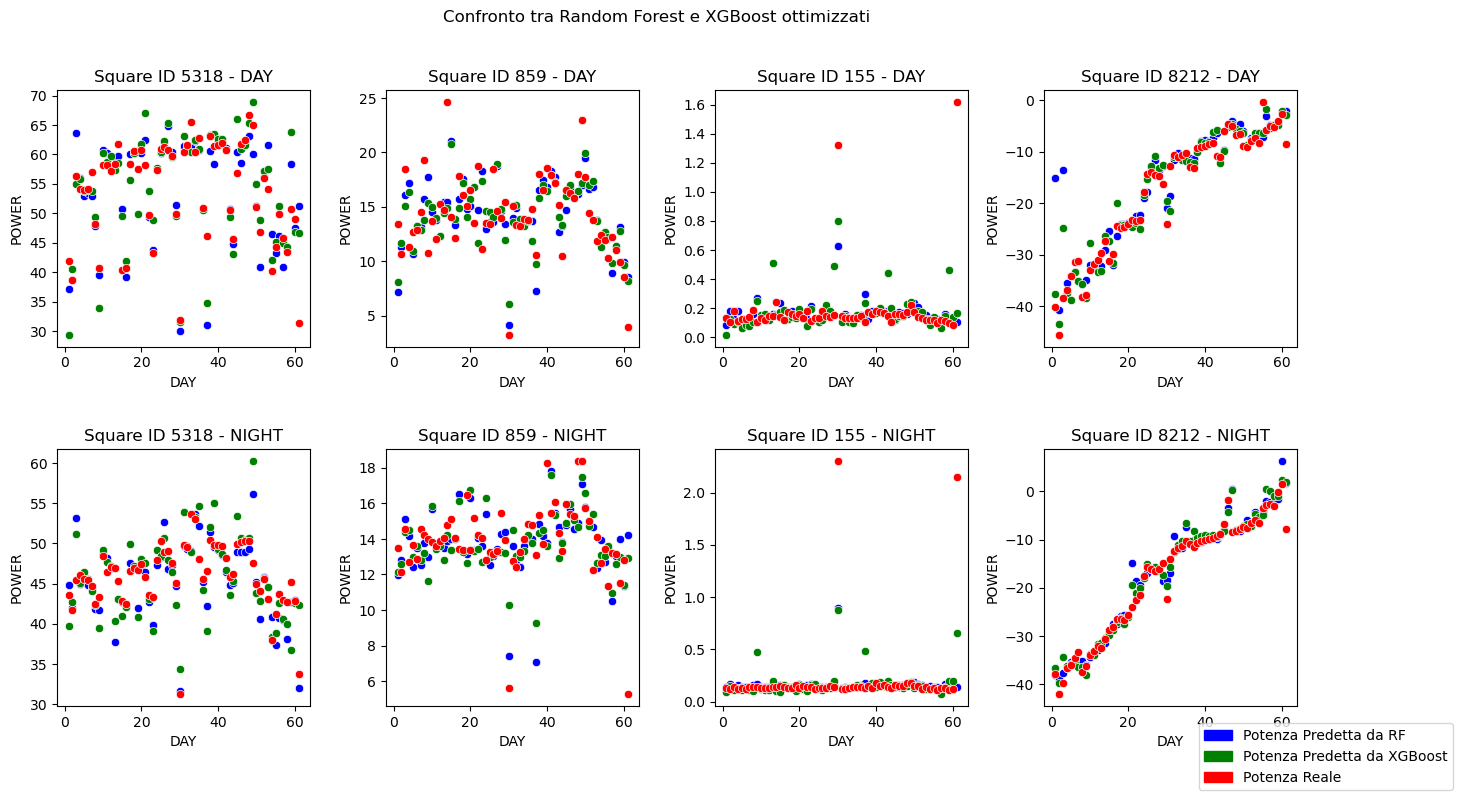

In [100]:
#PLotto il grafico per confrontare modello RF con XGBoost


#Fisso gli squareid che voglio vedere perchè rappresentativi di tutti i possibili range di potenza
square_ids = [5318, 859, 155, 8212]

# Creazione dei subplots per i grafici
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Confronto tra Random Forest e XGBoost ottimizzati')

#Itero sugli square_ids e sulle fasce orarie
for i, square_id in enumerate(square_ids):
    #Filtro i dataframe per Giorno
    filtered_df_day = predictions_day[predictions_day['SQUAREID'] == square_id]
    
    #Filtro i dtaaframe per Notte
    filtered_df_nig = predictions_nig[predictions_nig['SQUAREID'] == square_id]

    #Potto per Giorno
    ax = axs[0, i]
    scatter_day = sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_GRID', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_day, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - DAY'.format(square_id))
    
    #PLotto per Notte
    ax = axs[1, i]
    scatter_nig = sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_GRID', color='blue', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_PRED_XGB_GRID', color='green', ax=ax)
    sns.scatterplot(data=filtered_df_nig, x='DAY', y='POW_TO_PRED', color='red', ax=ax)
    ax.set_xlabel('DAY')
    ax.set_ylabel('POWER')
    ax.set_title('Square ID {} - NIGHT'.format(square_id))

#Creo la legenda in questo modo sennò mi dà warning e non mi mette 1 unica legenda
pred_patch = mpatches.Patch(color='blue', label='Potenza Predetta da RF')
grid_patch = mpatches.Patch(color='green', label='Potenza Predetta da XGBoost')
real_patch = mpatches.Patch(color='red', label='Potenza Reale')

# Aggiunta della legenda unica
fig.legend(handles=[pred_patch, grid_patch, real_patch], loc='lower right')

# Regola lo spazio tra i plot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Mostra i plot
plt.show()


Come detto in precedenza pensiamo sia impossibile dichiarare un modello migliore in assoluto. Si può però osservare alcuni riquadri e esprimere in quegli specifici casi delle considerazioni.
Si nota come nello squareid 8212, sia durante il giorno che durante la notte, il modello che sbaglia leggermente meno è XGBoost, dove non cerca (sbagliando) di trovare picchi verso lo 0 (sono pichi anche se "verso lo 0" perchè la potenza in media è negativa) un po' randomici come fa Random Forest ed in generale, come ci si aspettvava, avendo meno variazioni durante la notte i due modelli performano meglio nella suddetta fascia.
Per lo square id 155 se per la fascia nottuna sono simili (leggermente meglio random forest), mentre per la fascia diurna questa volta è il modello con Random Forest che non cerca picchi un po' a caso come XGBoost (cosa che il modello non ottimizzato non faceva).
Per gli altri due squareid è difficile esprimere grandi differenze, i tratti caratteristici li trovano entrambi e cercano nella stessa maniera di seguire al meglio i possibili cambi di potenza tra un giorno e l'altro

Si nota in generale un miglior rendimento pee la fascia notturna dove ho meno varianza, sembra che entrambi i modelli prediligano questo tipo di scenario rispetto a quello in cui ho potenza e varianza elevata. Si riuscirà ad ipotizzare una risposta al perchè di questo comportamento solamente quando si sarà analizzato pure il datatset di Trento.

Si è quindi fatto notare differenze non solo al variare dello squareid ma anche al variare della fascia oraria: fasce orarie che da un giorno all'altro possono variare molto mi creano un grande problema nel riuscire ad ottenere una buona predizione sui dati. Questo quindi è un qualcosa che cambia profondamente rispetto al caso della classificazione dove invece avevo un problema diciamo più "livellato" tra le due fasce in cui si notavano sì qualche differenza ma niente di veramente tangibile, soprattutto cercando una classificazione finale degli squareid che tenesse conto di un andamento medio nel mese. Questo significa che il prendere fasce orarie più sottili non causa di per sè un danno alla predizione perchè rimarranno quelli, il problema è la variazione di un giorno all'altro che può rendere la previsione alquanto discutibile. Prendere quindi fasce orarie di 1 sola ora è rischioso per quelle fasce in cui potrebbe esserci grande distanza tra i vari giorni, problema in cui prendendo fasce più larghe si assottiglia perchè la media tra le diverse ore dovrebbe contenere queste variazioni improvvise

Salvo quindi i modelli ottimizzati basati su Random Forest e su XGBoost

In [101]:
from joblib import dump, load

#Definisco i modelli
models = {
    'XGBoost- Day': {'filename': 'XGB_reg_grid_day.pkl', 'value': xgb_grid_day},
    'XGBoost- Night': {'filename': 'XGB_reg_grid_nig.pkl', 'value': xgb_grid_nig},
    'Random Forest- Day Reg': {'filename': 'RF_reg_grid_day.pkl', 'value': rf_grid_day},
    'Random Forest- Night Reg': {'filename': 'RF_reg_grid_nig.pkl', 'value': rf_grid_nig}
}

#Salvo i modelli nel file definito sopra
for model_name, model_info in models.items():
    dump(model_info['value'], model_info['filename'])